# Adam算法
Adam（Adaptive Moment Estimation）是一种结合了动量法和 RMSProp 的自适应学习率的优化算法。Adam 在训练深度神经网络时表现出色，因为它能够自适应地调整每个参数的学习率，并具有对动量项和梯度平方项的指数加权移动平均。

 Adam 的更新规则：

$ m_t = \beta_1 m_{t-1} + (1 - \beta_1) \nabla J(\theta_t) $ <br>
$ v_t = \beta_2 v_{t-1} + (1 - \beta_2) (\nabla J(\theta_t))^2 $ <br>
$ \hat{m}_t = \frac{m_t}{1 - \beta_1^t} $ <br>
$ \hat{v}_t = \frac{v_t}{1 - \beta_2^t} $ <br>
$ \theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{\hat{v}_t} + \epsilon} \hat{m}_t $ <br>

其中：
- $ \theta_t $ 是参数在时间步 $ t $ 的值。
- $ \nabla J(\theta_t) $ 是关于参数的梯度。
- $ m_t $ 是动量项，表示梯度的指数加权移动平均。
- $ v_t $ 是梯度平方项的指数加权移动平均。
- $ \hat{m}_t $ 和 $ \hat{v}_t $ 是对动量项和梯度平方项的校正，用于解决初始训练阶段的偏差问题。
- $ \beta_1 $ 和 $ \beta_2 $ 是动量项和梯度平方项的衰减率，通常接近于1。
- $ \eta $ 是全局学习率，用于控制参数更新的步长。
- $ \epsilon $ 是一个小的常数，用于防止分母为零。

Adam 综合了动量法和 RMSProp 的优点，能够在不同参数上使用不同的学习率，对超参数的选择相对不敏感，因此在实践中广泛应用于深度学习的优化任务。


In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l


def init_adam_states(feature_dim):
    v_w, v_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    s_w, s_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    return ((v_w, s_w), (v_b, s_b))

def adam(params, states, hyperparams):
    beta1, beta2, eps = 0.9, 0.999, 1e-6
    for p, (v, s) in zip(params, states):
        with torch.no_grad():
            v[:] = beta1 * v + (1 - beta1) * p.grad
            s[:] = beta2 * s + (1 - beta2) * torch.square(p.grad)
            v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
            s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
            p[:] -= hyperparams['lr'] * v_bias_corr / (torch.sqrt(s_bias_corr) + eps)
        p.grad.data.zero_()
    hyperparams['t'] += 1

loss: 0.243, 0.016 sec/epoch


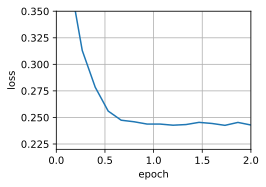

In [2]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(adam, init_adam_states(feature_dim), {'lr': 0.01, 't': 1}, data_iter, feature_dim);

loss: 0.242, 0.018 sec/epoch


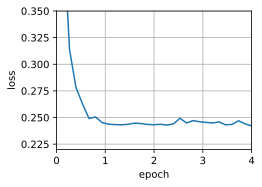

In [3]:
trainer = torch.optim.Adam
d2l.train_concise_ch11(trainer, {'lr': 0.01}, data_iter)

## Yogi
Adam算法也存在一些问题： 即使在凸环境下，当$S_t$的二次矩估计值爆炸时，它可能无法收敛。 (*Zaheer et al., 2018*)为$S_t$提出了的改进更新和参数初始化。

loss: 0.243, 0.013 sec/epoch


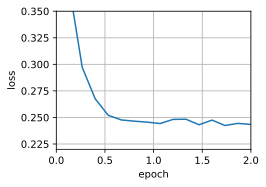

In [4]:
def yogi(params, states, hyperparams):
    beta1, beta2, eps = 0.9, 0.999, 1e-3
    for p, (v, s) in zip(params, states):
        with torch.no_grad():
            v[:] = beta1 * v + (1 - beta1) * p.grad
            s[:] = s + (1 - beta2) * torch.sign(
                torch.square(p.grad) - s) * torch.square(p.grad)
            v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
            s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
            p[:] -= hyperparams['lr'] * v_bias_corr / (torch.sqrt(s_bias_corr) + eps)
        p.grad.data.zero_()
    hyperparams['t'] += 1

data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(yogi, init_adam_states(feature_dim), {'lr': 0.01, 't': 1}, data_iter, feature_dim);